# TP 1: Multimodal Deep Generative Models

In this practical work, we will implement a generative mutimodal model.

**Abstract:**
We investigate deep generative models that can exchange multiple modalities bidirectionally, e.g., generating images from corresponding texts and vice versa. Recently, some studies handle multiple modalities on deep generative models, such as variational autoencoders (VAEs). However, these models typically assume that modalities are forced to have a conditioned relation, i.e., we can only generate modalities in one direction. To achieve our objective, we should extract a joint representation that captures high-level concepts among all modalities and through which we can exchange them bi-directionally. As described herein, we propose a joint multimodal variational autoencoder (JMVAE), in which all modalities are independently conditioned on joint representation. In other words, it models a joint distribution of modalities. Furthermore, to be able to generate missing modalities from the remaining modalities properly, we develop an additional method, JMVAE-kl, that is trained by reducing the divergence between JMVAE’s encoder and prepared networks of respective modalities. Our experiments show that our proposed method can obtain appropriate joint representation from multiple modalities and that it can generate and reconstruct them more properly than conventional VAEs. We further demonstrate that JMVAE can generate multiple modalities bidirectionally.



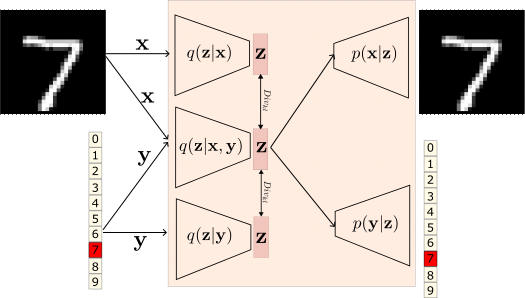

In [ ]:
!pip install tqdm torchvision tensorboardX kornia pixyz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 KB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.0/612.0 KB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.9/73.9 KB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 38.1 MB/s eta 0:00:00


In [ ]:
from __future__ import print_function
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from tensorboardX import SummaryWriter

from tqdm import tqdm

batch_size = 128
epochs = 100
seed = 1
torch.manual_seed(seed)

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

## 1) Get Mnist (*)

The MNIST database (Modified National Institute of Standards and Technology database) is a large collection of handwritten digits

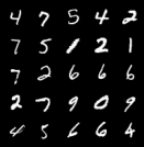

In [ ]:
# MNIST
root = '../data'
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Lambda(lambd=lambda x: x.view(-1))])   # image becomes vector
kwargs = {'batch_size': batch_size, 'num_workers': 1, 'pin_memory': True}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root=root, train=True, transform=transform, download=True),
    shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root=root, train=False, transform=transform),
    shuffle=False, **kwargs)

## 2) Joint VAE:
# 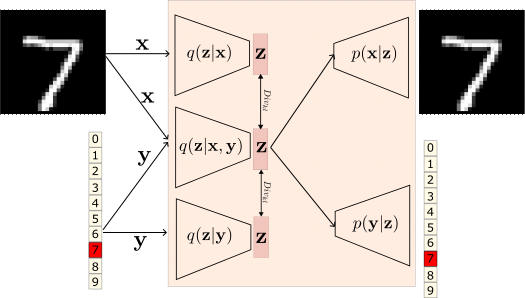

In [ ]:
from pixyz.distributions import Normal, Bernoulli, Categorical
from pixyz.losses import KullbackLeibler
from pixyz.models import VAE
from pixyz.utils import print_latex

x_dim = 784
y_dim = 10
z_dim = 64

### 2.1) inference model q(z|x,y)


In [ ]:
class Inference(Normal):
    def __init__(self):
        super(Inference, self).__init__(var=["z"], cond_var=["x","y"], name="q")

        self.fc1 = nn.Linear(x_dim+y_dim, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc31 = nn.Linear(512, z_dim)
        self.fc32 = nn.Linear(512, z_dim)

    def forward(self, x, y):
        h = F.relu(self.fc1(torch.cat([x, y], 1)))
        h = F.relu(self.fc2(h))        
        return {"loc": self.fc31(h), "scale": F.softplus(self.fc32(h))}

### 2.2) inference model q(z|x)

In [ ]:
class InferenceX(Normal):
    def __init__(self):
        super(InferenceX, self).__init__(var=["z"], cond_var=["x"], name="q")

        self.fc1 = nn.Linear(x_dim, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc31 = nn.Linear(512, z_dim)
        self.fc32 = nn.Linear(512, z_dim)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))        
        return {"loc": self.fc31(h), "scale": F.softplus(self.fc32(h))}

### 2.3) inference model q(z|y)


In [ ]:
class InferenceY(Normal):
    def __init__(self):
        super(InferenceY, self).__init__(var=["z"], cond_var=["y"], name="q")

        self.fc1 = nn.Linear(y_dim, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc31 = nn.Linear(512, z_dim)   # media
        self.fc32 = nn.Linear(512, z_dim)   # matriz de covariância

    def forward(self, y):
        h = F.relu(self.fc1(y))
        h = F.relu(self.fc2(h))        
        return {"loc": self.fc31(h), "scale": F.softplus(self.fc32(h))}

### 2.4) generative model p(x|z)



In [ ]:
# generative model p(x|z)    
class GeneratorX(Bernoulli):
    def __init__(self):
        super(GeneratorX, self).__init__(var=["x"], cond_var=["z"], name="p")

        self.fc1 = nn.Linear(z_dim, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, x_dim)

    def forward(self, z):
        h = F.relu(self.fc1(z))
        h = F.relu(self.fc2(h))
        return {"probs": torch.sigmoid(self.fc3(h))}

### 2.5) generative model p(y|z)

In [ ]:
# generative model p(y|z)    
class GeneratorY(Categorical):
    def __init__(self):
        super(GeneratorY, self).__init__(var=["y"], cond_var=["z"], name="p")

        self.fc1 = nn.Linear(z_dim, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, y_dim)

    def forward(self, z):
        h = F.relu(self.fc1(z))
        h = F.relu(self.fc2(h))
        return {"probs": F.softmax(self.fc3(h), dim=1)}

### 2.6) Generatives + Inferences:


In [ ]:
  # prior model p(z)
prior = Normal(loc=torch.tensor(0.), scale=torch.tensor(1.),
               var=["z"], features_shape=[z_dim], name="p_{prior}").to(device)

p_x = GeneratorX().to(device)
p_y = GeneratorY().to(device)

q = Inference().to(device)
q_x = InferenceX().to(device)
q_y = InferenceY().to(device)

p = p_x * p_y

In [ ]:
print(p)
print_latex(p)

Distribution:
  p(x,y|z) = p(y|z)p(x|z)
Network architecture:
  p(x|z):
  GeneratorX(
    name=p, distribution_name=Bernoulli,
    var=['x'], cond_var=['z'], input_var=['z'], features_shape=torch.Size([])
    (fc1): Linear(in_features=64, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=512, bias=True)
    (fc3): Linear(in_features=512, out_features=784, bias=True)
  )
  p(y|z):
  GeneratorY(
    name=p, distribution_name=Categorical,
    var=['y'], cond_var=['z'], input_var=['z'], features_shape=torch.Size([])
    (fc1): Linear(in_features=64, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=512, bias=True)
    (fc3): Linear(in_features=512, out_features=10, bias=True)
  )


<IPython.core.display.Math object>

### 2.7) Regularisation

In [ ]:
kl = KullbackLeibler(q, prior)
kl_x = KullbackLeibler(q, q_x)
kl_y = KullbackLeibler(q, q_y)

regularizer = kl + kl_x + kl_y
print(regularizer)
print_latex(regularizer)

D_{KL} \left[q(z|x,y)||p_{prior}(z) \right] + D_{KL} \left[q(z|x,y)||q(z|x) \right] + D_{KL} \left[q(z|x,y)||q(z|y) \right]


<IPython.core.display.Math object>

### 2.8) Define the model

In [ ]:
model = VAE(q, p, other_distributions=[q_x, q_y],
            regularizer=regularizer, optimizer=optim.Adam, optimizer_params={"lr":1e-3})
print(model)
print_latex(model)

Distributions (for training):
  q(z|x,y), p(x,y|z), q(z|x), q(z|y)
Loss function:
  mean \left(D_{KL} \left[q(z|x,y)||p_{prior}(z) \right] + D_{KL} \left[q(z|x,y)||q(z|x) \right] + D_{KL} \left[q(z|x,y)||q(z|y) \right] - \mathbb{E}_{q(z|x,y)} \left[\log p(x,y|z) \right] \right)
Optimizer:
  Adam (
  Parameter Group 0
      amsgrad: False
      betas: (0.9, 0.999)
      capturable: False
      differentiable: False
      eps: 1e-08
      foreach: None
      fused: False
      lr: 0.001
      maximize: False
      weight_decay: 0
  )


<IPython.core.display.Math object>

## Train (*)

In [ ]:

def train(epoch):
    train_loss = 0
    for x, y in tqdm(train_loader):
        x = x.to(device)
        y = torch.eye(10)[y].to(device)        
        loss = model.train({"x": x, "y": y})
        train_loss += loss
 
    train_loss = train_loss * train_loader.batch_size / len(train_loader.dataset)
    print('\n Epoch: {} Train loss: {:.4f}'.format(epoch, train_loss))
    return train_loss

In [ ]:
def test():    
    test_loss = 0
    for x, y in test_loader:
        x = x.to(device)
        y = torch.eye(10)[y].to(device)
        loss = model.test({"x": x, "y": y})
        test_loss += loss

    test_loss = test_loss * test_loader.batch_size / len(test_loader.dataset)
    print('\n Test loss: {:.4f}'.format(test_loss))
    return test_loss

### RUN

100%|██████████| 469/469 [00:20<00:00, 22.66it/s]


 Epoch: 1 Train loss: 190.9595



 Test loss: 162.2389


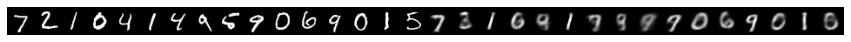

100%|██████████| 469/469 [00:17<00:00, 27.41it/s]


 Epoch: 2 Train loss: 149.7668



 Test loss: 142.4894


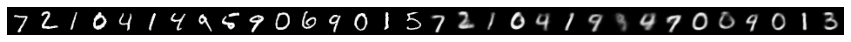

100%|██████████| 469/469 [00:18<00:00, 25.91it/s]


 Epoch: 3 Train loss: 136.6176



 Test loss: 133.5941


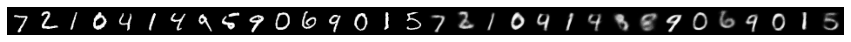

100%|██████████| 469/469 [00:17<00:00, 27.43it/s]


 Epoch: 4 Train loss: 131.0089



 Test loss: 129.6388


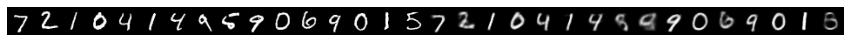

100%|██████████| 469/469 [00:18<00:00, 25.68it/s]


 Epoch: 5 Train loss: 127.8816



 Test loss: 127.1797


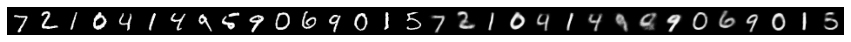

100%|██████████| 469/469 [00:17<00:00, 26.57it/s]


 Epoch: 6 Train loss: 125.8463



 Test loss: 125.4679


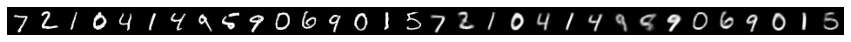

100%|██████████| 469/469 [00:18<00:00, 25.82it/s]


 Epoch: 7 Train loss: 124.3847



 Test loss: 124.1396


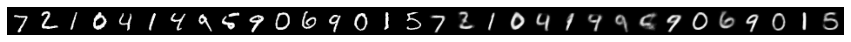

100%|██████████| 469/469 [00:17<00:00, 26.19it/s]


 Epoch: 8 Train loss: 123.1977



 Test loss: 123.4333


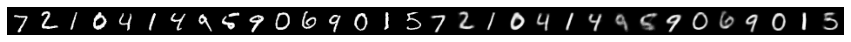

100%|██████████| 469/469 [00:18<00:00, 24.88it/s]


 Epoch: 9 Train loss: 122.3297



 Test loss: 123.0044


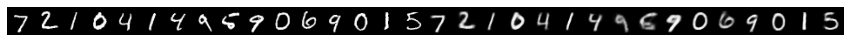

100%|██████████| 469/469 [00:18<00:00, 25.23it/s]


 Epoch: 10 Train loss: 121.5679



 Test loss: 122.1787


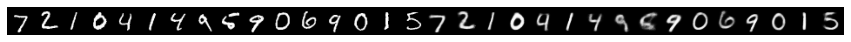

100%|██████████| 469/469 [00:17<00:00, 26.45it/s]


 Epoch: 11 Train loss: 120.9654



 Test loss: 122.2152


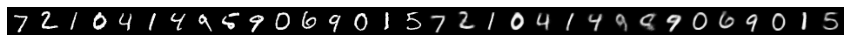

100%|██████████| 469/469 [00:18<00:00, 25.44it/s]


 Epoch: 12 Train loss: 120.4109



 Test loss: 121.4503


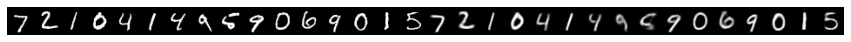

100%|██████████| 469/469 [00:18<00:00, 25.21it/s]


 Epoch: 13 Train loss: 119.8924



 Test loss: 120.8760


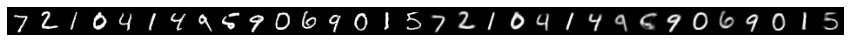

100%|██████████| 469/469 [00:18<00:00, 25.92it/s]


 Epoch: 14 Train loss: 119.3286



 Test loss: 120.2986


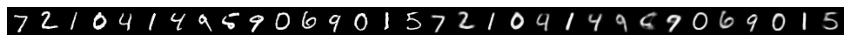

100%|██████████| 469/469 [00:19<00:00, 24.45it/s]



 Epoch: 15 Train loss: 118.8729

 Test loss: 119.9863


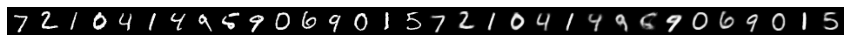

100%|██████████| 469/469 [00:17<00:00, 26.20it/s]


 Epoch: 16 Train loss: 118.4812



 Test loss: 120.0522


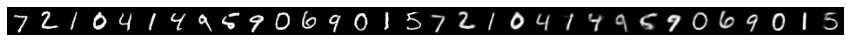

100%|██████████| 469/469 [00:18<00:00, 25.53it/s]


 Epoch: 17 Train loss: 118.1915



 Test loss: 119.7490


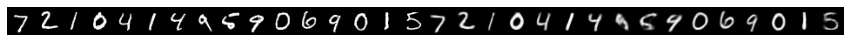

100%|██████████| 469/469 [00:18<00:00, 25.39it/s]


 Epoch: 18 Train loss: 117.9089



 Test loss: 119.5353


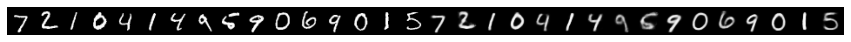

100%|██████████| 469/469 [00:18<00:00, 25.97it/s]


 Epoch: 19 Train loss: 117.6435



 Test loss: 119.3310


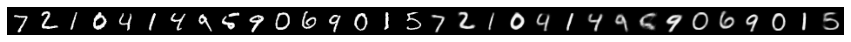

100%|██████████| 469/469 [00:20<00:00, 23.32it/s]


 Epoch: 20 Train loss: 117.4042



 Test loss: 118.8143


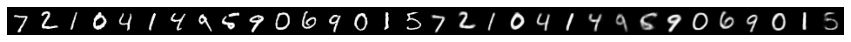

100%|██████████| 469/469 [00:17<00:00, 26.38it/s]


 Epoch: 21 Train loss: 117.2006



 Test loss: 118.8647


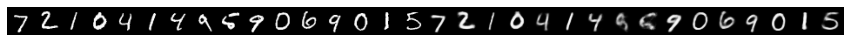

100%|██████████| 469/469 [00:17<00:00, 26.13it/s]


 Epoch: 22 Train loss: 116.9677



 Test loss: 118.8598


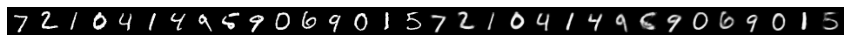

100%|██████████| 469/469 [00:18<00:00, 25.98it/s]


 Epoch: 23 Train loss: 116.7959



 Test loss: 118.7309


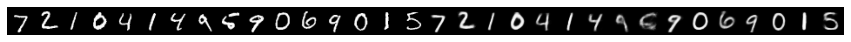

100%|██████████| 469/469 [00:18<00:00, 25.47it/s]


 Epoch: 24 Train loss: 116.5993



 Test loss: 118.3847


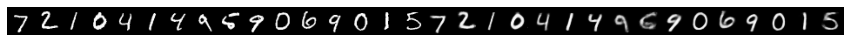

100%|██████████| 469/469 [00:19<00:00, 24.60it/s]


 Epoch: 25 Train loss: 116.4228



 Test loss: 118.1478


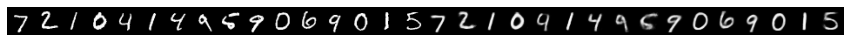

100%|██████████| 469/469 [00:18<00:00, 26.02it/s]


 Epoch: 26 Train loss: 116.2910



 Test loss: 118.2910


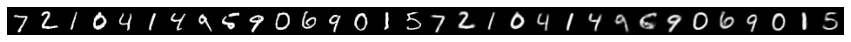

100%|██████████| 469/469 [00:18<00:00, 25.48it/s]


 Epoch: 27 Train loss: 116.1233



 Test loss: 118.1203


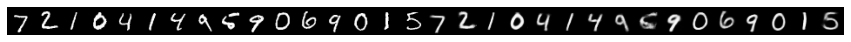

100%|██████████| 469/469 [00:19<00:00, 24.01it/s]


 Epoch: 28 Train loss: 116.0301



 Test loss: 117.9618


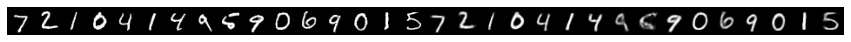

100%|██████████| 469/469 [00:18<00:00, 25.66it/s]


 Epoch: 29 Train loss: 115.8866



 Test loss: 117.9799


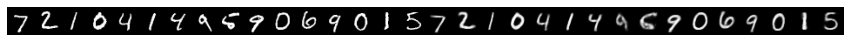

100%|██████████| 469/469 [00:18<00:00, 25.23it/s]


 Epoch: 30 Train loss: 115.6855



 Test loss: 117.8392


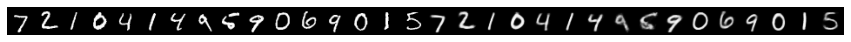

100%|██████████| 469/469 [00:19<00:00, 23.94it/s]


 Epoch: 31 Train loss: 115.5682



 Test loss: 117.5691


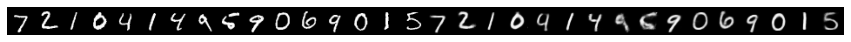

100%|██████████| 469/469 [00:18<00:00, 24.80it/s]



 Epoch: 32 Train loss: 115.4657

 Test loss: 117.8094


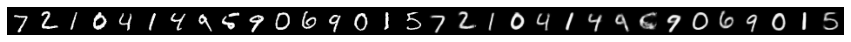

100%|██████████| 469/469 [00:18<00:00, 25.80it/s]


 Epoch: 33 Train loss: 115.3854



 Test loss: 117.6771


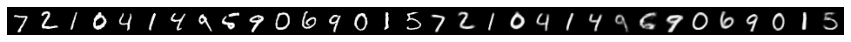

100%|██████████| 469/469 [00:18<00:00, 24.96it/s]


 Epoch: 34 Train loss: 115.2578



 Test loss: 117.6271


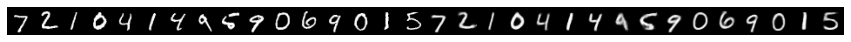

 86%|████████▌ | 403/469 [00:15<00:02, 25.66it/s]


KeyboardInterrupt: ignored

In [ ]:
import pixyz
import datetime
from torchvision.utils import make_grid
import kornia as K
import matplotlib.pyplot as plt
import numpy as np


def plot_reconstrunction(x, y):
    with torch.no_grad():
        z = q.sample({"x": x, "y": y}, return_all=False)
        recon_batch = p_x.sample_mean(z).view(-1, 1, 28, 28)
    
        comparison = torch.cat([x.view(-1, 1, 28, 28), recon_batch]).cpu()
        return comparison

def show_images(images, show: bool = True, save: str = None):
    plt.figure(figsize=(15, 15))
    out: torch.Tensor = make_grid(images, nrow=32, padding=2)
    out_np: np.array = K.tensor_to_image(out)
    plt.imshow(out_np)
    plt.axis('off')
    if show:
        plt.show()
    if save is not None:
        plt.savefig(save)
        plt.close()


_x, _y = next(iter(test_loader))
_x = _x.to(device)
_y = torch.eye(10)[_y].to(device)

for epoch in range(1, epochs + 1):
    train_loss = train(epoch)
    test_loss = test()
    recon = plot_reconstrunction(_x[:16], _y[:16])
    show_images(recon)


## 4) Evaluation

In [ ]:
from torchvision.utils import make_grid
import kornia as K
import matplotlib.pyplot as plt
import numpy as np


def plot_reconstrunction(x, y):
    with torch.no_grad():
        z = q.sample({"x": x, "y": y}, return_all=False)
        recon_batch = p_x.sample_mean(z).view(-1, 1, 28, 28)
    
        comparison = torch.cat([x.view(-1, 1, 28, 28), recon_batch]).cpu()
        return comparison


def plot_reconstrunction_missing(x):
    with torch.no_grad():
        # to do
        z = q_x.sample({"x":x}, return_all=False)
        reconstruction = p_x.sample_mean(z).view(-1, 1, 28, 28)
        comparison = torch.cat([x.view(-1, 1, 28, 28), reconstruction]).cpu()
        return comparison

def plot_image_from_label(x, y):
    with torch.no_grad():
        # to do
        z = q_y.sample({"y":y}, return_all=False)
        reconstruction = p_x.sample_mean(z).view(-1, 1, 28, 28)
        comparison = torch.cat([x.view(-1, 1, 28, 28), reconstruction]).cpu()
        return comparison

def get_labels_from_images(x):
    with torch.no_grad():
        # to do
        z = q_x.sample({"x":x}, return_all=False)
        reconstruction = p_y.sample_mean(z)
        return reconstruction


def show_images(images, show: bool = True, save: str = None):
    plt.figure(figsize=(15, 15))
    out: torch.Tensor = make_grid(images, nrow=8, padding=2, pad_value=1)
    out_np: np.array = K.tensor_to_image(out)
    plt.imshow(out_np)
    plt.axis('off')
    if show:
        plt.show()
    if save is not None:
        plt.savefig(save)
        plt.close()


_x, _y = next(iter(test_loader))
_x = _x.to(device)
_y = torch.eye(10)[_y].to(device)

### 4.1) Reconstruction

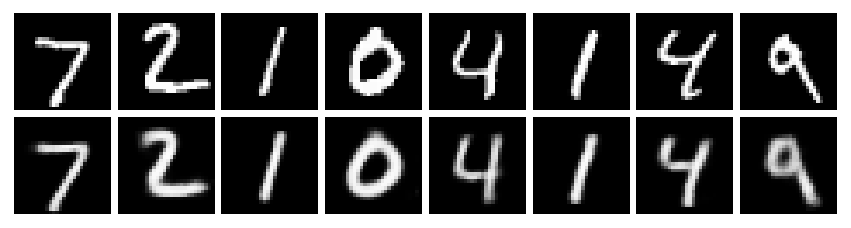

In [ ]:
recon = plot_reconstrunction(_x[:8], _y[:8])
show_images(recon)

### 4.2) Reconstruction in the missing data

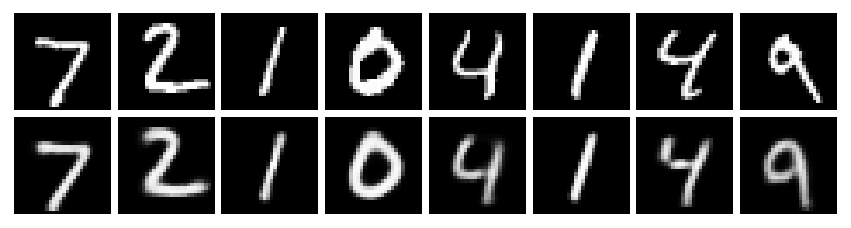

In [ ]:
recon_missing = plot_reconstrunction_missing(_x[:8])
show_images(recon_missing)

### 4.3) Cross-modality

Labels:  tensor([7, 2, 1, 0, 4, 1, 4, 9])


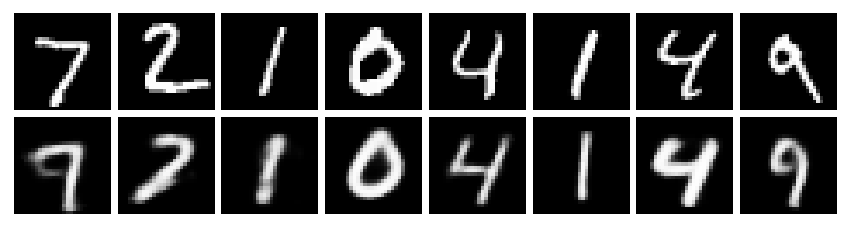

In [ ]:
# y  to   x

sample = plot_image_from_label(_x[:8], _y[:8])
print("Labels: ", torch.argmax(_y[:8], dim=1).cpu())
show_images(sample)

Images:


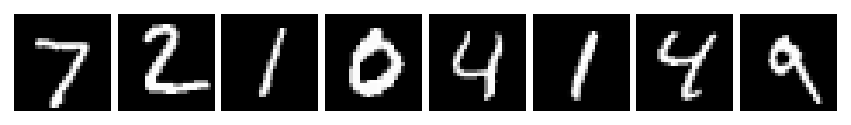

     Real labels:  tensor([7, 2, 1, 0, 4, 1, 4, 9])
Predicted labels:  tensor([7, 2, 1, 0, 4, 1, 4, 9])


In [ ]:
# x  to   y

print("Images:")
show_images(_x[:8].view(-1, 1, 28, 28).cpu())
recon_labels = get_labels_from_images(_x[:8])
print("     Real labels: ", torch.argmax(_y[:8], dim=1).cpu())
print("Predicted labels: ", torch.argmax(recon_labels, dim=1).cpu())